In [1]:
# library imports
import numpy as np
import pandas as pd
import pmdarima as pm

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Data set up

In [2]:
# data read
metadata = pd.read_csv("../data/russian_meta_data.csv")

# usual method
# data = pd.read_csv("../data/russian_data_tf.csv", parse_dates=["date"])

# distillation from LSTM
# step 0 (usual destillation from LSTM)
# data = pd.read_csv("../data/russian_LSTM_predictions+rest_train.csv", parse_dates=["date"])
# step 1 (mean of real and forecasted)
# data = pd.read_csv("../data/russian_LSTM_predictions_step1.csv", parse_dates=["date"])
# step 2 (mean of real and forecasted)
# data = pd.read_csv("../data/russian_LSTM_predictions_step2.csv", parse_dates=["date"])

# distillation from GB
# step 0 (usual destillation from GB)
# data = pd.read_csv("../data/russian_GB_predictions_distillation.csv", parse_dates=["date"])
# step 1 (mean of real and forecasted) (from GB)
# data = pd.read_csv("../data/russian_GB_predictions_step1.csv", parse_dates=["date"])
# step 2 (mean of real and forecasted for otliers - where big errors)
data = pd.read_csv("../data/russian_GB_predictions_step2.csv", parse_dates=["date"])


# target variable = GDP
target_variable = "gdp"
target_lag = 1 # GDP published after completion of the next month

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
train_start_date = "2004-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2023-12-01"

# train and test datasets
train = data.loc[(data.date >= train_start_date) & (data.date <= train_end_date), :].reset_index(drop=True)
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True) # let test set data begin from training begin, data lag/time series for test sets can go back into the training data

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [3]:
data.tail()

,date,ibved,cpi,oil_price,rate,exchange_rate,m2,us_cpi,PMI,unemployment,gdp
237,2023-10-01,-0.003476,0.007528,-0.050174,0.056536,0.018606,0.007443,0.006135,-0.020110,-0.042565,NaN
238,2023-11-01,-0.002770,0.008603,-0.054758,0.138056,-0.071001,0.016074,0.000000,-0.022388,-0.000486,NaN
239,2023-12-01,0.009221,0.004878,-0.016119,0.031674,0.014419,0.013206,0.000000,0.062977,0.017713,0.015419
240,2024-01-01,-0.006672,0.005015,-0.004557,0.033918,-0.000310,0.014697,0.006098,-0.010772,-0.038277,NaN
241,2024-02-01,NaN,0.004907,0.022936,0.000000,0.011464,0.017927,0.000000,-0.052632,NaN,NaN


# Training the model

In [4]:
# training ARMA model for order
train_series = train.loc[~pd.isna(train[target_variable]), target_variable].reset_index(drop=True) # only the target series is used in the ARMA model
model = pm.auto_arima(train_series, seasonal=False, stationary=True)
ar_order = model.order[0]
ma_order = model.order[2]
print(ar_order, ma_order)

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1 0


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


# Testing the model on artificial data vintages

In [5]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

In [10]:
# dates in the test set (MY!!!!!!!!!! - testing on train data)
dates = (
        pd.date_range(train_start_date, train_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(train.loc[train.date.isin(dates), target_variable].values)[8:]
# actuals
# dates

In [6]:
# original (for test predicting and valuation)
pred_dict = {k: [] for k in lags}
for lag in lags:
    for date in dates:
        test_series = test.loc[test.date <= date, ["date", target_variable]]
        test_series.iloc[len(test_series)+lag-1-target_lag:,1] = np.nan # simulated vintage
        
        # make sure target variable isn't given
        test_series.loc[test_series.date == date,target_variable] = np.nan
        
        ts = test_series.loc[~pd.isna(test_series[target_variable])].reset_index(drop=True)
        ts_dates = ts.date
        ts_series = ts[target_variable]

        ts_model = pm.arima.ARIMA((ar_order, 0, ma_order))
        preds = ts_model.fit_predict(ts_series)

        # make sure getting right date for prediction
        final_dates = pd.date_range(ts_dates[0], periods=len(ts_dates)+10, freq="3MS")
        final_preds = list(ts_series) + list(preds)
        final = pd.DataFrame({"date":final_dates, "preds":final_preds})
        pred = final.loc[final.date == date, "preds"].values[0]
        
        pred_dict[lag].append(pred)

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\User\AppData\Roamin

In [11]:
# my (for train predicting and valuation)
pred_dict = {k: [] for k in lags}
for lag in lags:
    for date in dates[8:]:
        test_series = train.loc[train.date <= date, ["date", target_variable]]
        test_series.iloc[len(test_series)+lag-1-target_lag:,1] = np.nan # simulated vintage
        
        # make sure target variable isn't given
        test_series.loc[test_series.date == date,target_variable] = np.nan
        
        ts = test_series.loc[~pd.isna(test_series[target_variable])].reset_index(drop=True)
        ts_dates = ts.date
        ts_series = ts[target_variable]

        ts_model = pm.arima.ARIMA((ar_order, 0, ma_order))
        # print(date, ts_series)
        preds = ts_model.fit_predict(ts_series)

        # make sure getting right date for prediction
        final_dates = pd.date_range(ts_dates[0], periods=len(ts_dates)+10, freq="3MS")
        final_preds = list(ts_series) + list(preds)
        final = pd.DataFrame({"date":final_dates, "preds":final_preds})
        pred = final.loc[final.date == date, "preds"].values[0]
        
        pred_dict[lag].append(pred)

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-

# Assess and visualize model performance

In [7]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE", "MAE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2)),
        "MAE":np.mean(np.abs(np.array(actuals) - np.array(pred_dict[lag])))
    }, index=[0])
    performance = performance.append(tmp).reset_index(drop=True)
performance.round(4)

,Vintage,RMSE,MAE
0,-2,0.0269,0.0150
1,-1,0.0315,0.0157
2,0,0.0315,0.0157
3,1,0.0315,0.0157
4,2,0.0315,0.0157


''

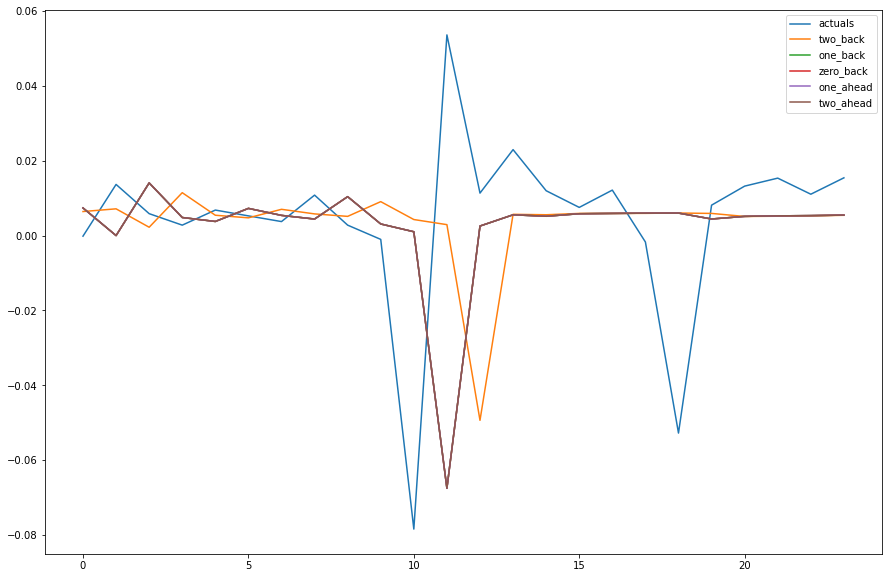

In [29]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [9]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test.copy()
ts_series = new_data.loc[~pd.isna(new_data[target_variable]), target_variable]
ts_model = pm.arima.ARIMA((ar_order, 0, ma_order))
preds = ts_model.fit_predict(ts_series)

In [10]:
# obtain prediction for the new period
preds[0]

0.006842559688019557